In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import weather_routing
import pandas
import math

In [3]:
year = 2024
##################
min_lat = 21.1
max_lat = 34.1
max_lng = -118
min_lng = -158
# Waypoints for the TransPac 
waypoints = pandas.DataFrame([
    (33.69853, -118.25085, 'Pt. Fermin Bouy'),
    (33.48177, -118.64101, 'Catalina West End'),
    #(21.24296, -157.81775, 'Diamond Head Bouy'),
            ], columns=['lat', 'lng', 'name'])
# July 1st, 12:00 PST
Start_Date = f"{year}0701"
Start_Time = 19 #19:00 UTC
##################
#grib_files_dir = "historical_gribs/2024"
wind_data_dir = f"historical_wind_data/{year}"

In [4]:
waypoints

lat        lng               name
0  33.69853 -118.25085    Pt. Fermin Bouy
1  33.48177 -118.64101  Catalina West End

In [5]:
# rhumb_route, all_routes = weather_routing.route_all_paths(
#     waypoints, 
#     start_date=Start_Date, 
#     start_time=Start_Time,
#     wind_data_dir=wind_data_dir,
#     gps_bounds=[min_lat,max_lat,max_lng,min_lng],
#     max_deg_deviation_from_rhumb=90
# )

In [6]:
#len(all_routes)


In [7]:
#all_routes

In [8]:
# import plotly.graph_objects as go
# import plotly.express as px

# # Create the figure
# fig = go.Figure()



# fig.add_trace(go.Scattermapbox(
#     lat=rhumb_route['lat'],
#     lon=rhumb_route['lng'],
#     mode='lines',
#     line=dict(color='blue', width=2),
#     hovertext=rhumb_route['date']
# ))
# for route in all_routes:
#     route = pandas.DataFrame(route)
    
#     # Add the first route (red line)
#     fig.add_trace(go.Scattermapbox(
#         lat=route['lat'],
#         lon=route['lng'],
#         mode='lines',
#         line=dict(color='red', width=2),
#         hovertext=route['date']
#     ))



# # Add scatter points for waypoints
# scatter_points = px.scatter_mapbox(waypoints, 
#                                    lat="lat", 
#                                    lon="lng", 
#                                    hover_name="name")
# fig.add_traces(scatter_points.data)

# # Update layout for the map
# fig.update_layout(
#     mapbox_style="open-street-map",
#     mapbox_zoom=9,
#     mapbox_center={"lat": 33.7, "lon": -118.5},
#     margin={"r":0, "t":0, "l":0, "b":0},
#    # width=800,
#     height=600
# )

# # Show the plot
# fig.show()


In [9]:
(FCdate, FCtime,_) = weather_routing.get_grib_time(Start_Date, Start_Time)

In [10]:
rhumb_route, rhumb_route_t = weather_routing.simulate_shortest_path(
        waypoints.iloc[0]['lat'], waypoints.iloc[0]['lng'],
        waypoints.iloc[1]['lat'], waypoints.iloc[1]['lng'],
        simulation_time=0,
        FCdate=FCdate,
        FCtime=FCtime,
        wind_data_dir=wind_data_dir
        )
print(f"Rhumb route takes {rhumb_route_t} steps")

starting time: 20240701 18 2024-07-01 11:00:00-07:00
0: twa=132.2 mag=202.2 dtg=19.8 sog=4.7
1: twa=132.2 mag=206.3 dtg=16.3 sog=4.7
2: twa=135 mag=217.5 dtg=13.0 sog=4.4
3: twa=150 mag=237.7 dtg=10.1 sog=3.5
4: twa=150 mag=299.6 dtg=7.1 sog=3.5
5: twa=165 mag=257.4 dtg=4.2 sog=2.9
6: twa=165 mag=277.5 dtg=1.5 sog=2.9
7: twa=180 mag=250.8 dtg=1.1 sog=2.6
Rhumb route takes 8 steps


In [11]:
import copy

In [12]:
# shore_boundaries=[
#   [ (33.72042, -118.20665), #Long breach, PV
#     (33.7025267, -118.25570833),
#     (33.70421,-118.29362),
#     (33.71349, -118.31815667),
#     (33.73722, -118.40627),
#     (33.77504, -118.42992) ],
#   [ (33.31505, -118.28944), # Catalina 
#     (33.40954, -118.36371),
#     (33.47957, -118.53720),
#     (33.47954, -118.60711),
#     (33.44873, -118.59738)]
# ]

In [13]:
lat = waypoints.iloc[0]['lat']
lng = waypoints.iloc[0]['lng']
lat_start = lat
lng_start = lng
lat_end = waypoints.iloc[1]['lat']
lng_end = waypoints.iloc[1]['lng']
time_step_size = 1 #hour
isochrons={}
past_traveled_path = []
past_traveled_path.append({  #start
        'lat':lat,
        'lng':lng,
        'date': weather_routing.FCdatetime_to_localtime(FCdate, FCtime,0)
    })





In [14]:
def take_isochron_step(past_traveled_path, simulation_time, FCdate, FCtime, wind_data_dir,
                      max_deviation_angle=90, max_turn_angle=120):
    if simulation_time not in isochrons: isochrons[simulation_time]=[]
    lat = past_traveled_path[-1]['lat']
    lng = past_traveled_path[-1] ['lng']    
    boat_mag_history={}
    ###
    (grib_file_date, grib_file_time, hr_offset) = weather_routing.get_grib_time(
                                                        FCdate, FCtime, 
                                                            simulation_time)
    wind_data = weather_routing.load_historical_gfs_forecast(
                                                    wind_data_dir, grib_file_date, 
                                                      grib_file_time, hr_offset)
    (tws, twd) = weather_routing.get_wind_at_location_from_data(wind_data, lat, lng)
    polars = weather_routing.polar_rhiannon(tws)
    ###
    parent_isochron_routes = weather_routing.get_parent_isochron_routes(isochrons,lat,lng,simulation_time)
    ###
    for (angle,boat_speed) in polars:
        for delta_angle in (angle, -1*angle):
            boat_mag = (twd+delta_angle)%360
            if boat_mag in boat_mag_history: continue
            boat_mag_history[boat_mag]=1
            dev_angle = weather_routing.calculate_deviation(lat, lng, lat_end, lng_end, boat_mag)
            (dlat,dlng) = weather_routing.calculate_destination_latlng(lat,lng,boat_speed,boat_mag,time_step_size) # hour
            dist_to_dest = weather_routing.haversine_distance(dlat,dlng,lat_end,lng_end)
            # check if we should prune the path
            if dev_angle > 90:
                print(f"   mag {boat_mag} deviation={dev_angle} too big")
                continue
            if simulation_time > 0: # don't calculate turn angle on step 1
                turn_angle =  math.fabs((past_traveled_path[-1]['mag'] - boat_mag + 540) % 360 - 180)
                if turn_angle > max_turn_angle:
                    print(f"    mag {boat_mag} turn_angle={turn_angle} too big =============================")
                    continue
            if weather_routing.does_path_cross_boundary(lat, lng, dlat, dlng, weather_routing.shore_boundaries):
                print(f"    mag {boat_mag} crosses land")
                continue
            if weather_routing.does_path_cross_parent_path(lat,lng, dlat, dlng, parent_isochron_routes):
                print(f"    mag {boat_mag} crosses parent route")
                continue
            # save the path
            print(f"mag {boat_mag} ({lat},{lng}) ({dlat},{dlng})")
            traveled_path = copy.copy(past_traveled_path)
            traveled_path.append({
                'lat':dlat,
                'lng':dlng,
                'mag':boat_mag,
                'sog':boat_speed,
                'dtg':dist_to_dest,
                'twa':angle
            })
            isochrons[simulation_time].append(traveled_path)
            
            

In [15]:
simulation_time=0
isochrons[simulation_time]=[]
take_isochron_step(past_traveled_path, simulation_time, FCdate, FCtime,wind_data_dir)


   mag 118.1732808818415 deviation=118.23409440720371 too big
   mag 21.7732808818415 deviation=145.36590559279625 too big
   mag 121.9732808818415 deviation=114.4340944072037 too big
   mag 17.973280881841504 deviation=141.5659055927963 too big
   mag 129.9732808818415 deviation=106.4340944072037 too big
   mag 9.973280881841504 deviation=133.5659055927963 too big
   mag 144.9732808818415 deviation=91.4340944072037 too big
   mag 354.9732808818415 deviation=118.5659055927963 too big
mag 159.9732808818415 (33.69853,-118.25085) (33.60400718499465,-118.20948655499828)
   mag 339.9732808818415 deviation=103.5659055927963 too big
mag 179.9732808818415 (33.69853,-118.25085) (33.599430171631425,-118.25079451630212)
    mag 319.9732808818415 crosses land
mag 189.9732808818415 (33.69853,-118.25085) (33.60633940627002,-118.2703143622098)
    mag 309.9732808818415 crosses land
mag 204.9732808818415 (33.69853,-118.25085) (33.6314881873833,-118.28834792801968)
    mag 294.9732808818415 crosses lan

In [16]:
simulation_time=1
isochrons[simulation_time]=[]
for iso_ndx in range(len(isochrons[0])):
    take_isochron_step(isochrons[0][iso_ndx], simulation_time, FCdate, FCtime, wind_data_dir)

   mag 122.34912499406728 deviation=128.99903270416507 too big
   mag 25.949124994067276 deviation=134.60096729583495 too big
   mag 126.14912499406728 deviation=125.19903270416506 too big
   mag 22.14912499406728 deviation=130.80096729583494 too big
   mag 134.14912499406728 deviation=117.19903270416506 too big
   mag 14.149124994067279 deviation=122.80096729583494 too big
   mag 149.14912499406728 deviation=102.19903270416506 too big
   mag 359.1491249940673 deviation=107.80096729583488 too big
mag 164.14912499406728 (33.60400718499465,-118.20948655499828) (33.50722917252516,-118.17653324746281)
   mag 344.1491249940673 deviation=92.80096729583488 too big
mag 184.14912499406728 (33.60400718499465,-118.20948655499828) (33.50516677762818,-118.21808552256074)
    mag 324.1491249940673 turn_angle=164.17584411222578 too big =============================
mag 194.14912499406728 (33.60400718499465,-118.20948655499828) (33.513240279997284,-118.23692981942128)
    mag 314.1491249940673 turn_an

In [17]:
simulation_time=2
isochrons[simulation_time]=[]
for iso_ndx in range(len(isochrons[simulation_time-1])):
    take_isochron_step(isochrons[simulation_time-1][iso_ndx], simulation_time, FCdate, FCtime, wind_data_dir)

   mag 130.82210602456604 deviation=135.5455866534462 too big
   mag 34.42210602456605 deviation=128.05441334655382 too big
   mag 134.62210602456605 deviation=131.7455866534462 too big
   mag 30.62210602456605 deviation=124.2544133465538 too big
   mag 142.62210602456605 deviation=123.7455866534462 too big
   mag 22.62210602456605 deviation=116.2544133465538 too big
   mag 157.62210602456605 deviation=108.7455866534462 too big
   mag 7.622106024566051 deviation=101.2544133465538 too big
   mag 172.62210602456605 deviation=93.7455866534462 too big
    mag 352.62210602456605 turn_angle=171.52701896950123 too big =============================
mag 192.62210602456605 (33.50722917252516,-118.17653324746281) (33.41052162221315,-118.20247556152938)
    mag 332.62210602456605 turn_angle=168.47298103049877 too big =============================
mag 202.62210602456605 (33.50722917252516,-118.17653324746281) (33.42081983132607,-118.21967088179217)
    mag 322.62210602456605 turn_angle=158.47298103

In [18]:
simulation_time=3
isochrons[simulation_time]=[]
for iso_ndx in range(len(isochrons[simulation_time-1])):
    take_isochron_step(isochrons[simulation_time-1][iso_ndx], simulation_time, FCdate, FCtime, wind_data_dir)

   mag 136.01818196693915 deviation=145.12097742791417 too big
   mag 39.61818196693916 deviation=118.47902257208585 too big
   mag 139.81818196693916 deviation=141.32097742791416 too big
   mag 35.818181966939164 deviation=114.67902257208584 too big
   mag 147.81818196693916 deviation=133.32097742791416 too big
   mag 27.818181966939164 deviation=106.67902257208584 too big
   mag 162.81818196693916 deviation=118.32097742791416 too big
   mag 12.818181966939164 deviation=91.67902257208584 too big
   mag 177.81818196693916 deviation=103.32097742791416 too big
    mag 357.81818196693916 turn_angle=165.1960759423731 too big =============================
    mag 197.81818196693916 crosses land
    mag 337.81818196693916 turn_angle=145.1960759423731 too big =============================
    mag 207.81818196693916 crosses land
    mag 327.81818196693916 turn_angle=135.1960759423731 too big =============================
mag 222.81818196693916 (33.41052162221315,-118.20247556152938) (33.356263

In [19]:
simulation_time=4
isochrons[simulation_time]=[]
for iso_ndx in range(len(isochrons[simulation_time-1])):
    take_isochron_step(isochrons[simulation_time-1][iso_ndx], simulation_time, FCdate, FCtime, wind_data_dir)

   mag 137.92051266475795 deviation=153.85741686923257 too big
   mag 41.52051266475796 deviation=109.74258313076746 too big
   mag 141.72051266475796 deviation=150.05741686923255 too big
   mag 37.72051266475796 deviation=105.94258313076745 too big
   mag 149.72051266475796 deviation=142.05741686923255 too big
   mag 29.720512664757962 deviation=97.94258313076745 too big
   mag 164.72051266475796 deviation=127.05741686923255 too big
    mag 14.720512664757962 turn_angle=151.9023306978188 too big =============================
   mag 179.72051266475796 deviation=112.05741686923255 too big
    mag 359.72051266475796 turn_angle=136.9023306978188 too big =============================
   mag 199.72051266475796 deviation=92.05741686923255 too big
    mag 339.72051266475796 crosses parent route
    mag 209.72051266475796 crosses land
    mag 329.72051266475796 crosses parent route
    mag 224.72051266475796 crosses land
    mag 314.72051266475796 crosses parent route
    mag 239.7205126647579

In [20]:
simulation_time=5
isochrons[simulation_time]=[]
for iso_ndx in range(len(isochrons[simulation_time-1])):
    take_isochron_step(isochrons[simulation_time-1][iso_ndx], simulation_time, FCdate, FCtime, wind_data_dir)

    mag 140.21039784812672 turn_angle=143.93594755524248 too big =============================
   mag 43.810397848126726 deviation=148.96378068918887 too big
    mag 144.01039784812673 turn_angle=140.1359475552424 too big =============================
   mag 40.01039784812673 deviation=152.76378068918882 too big
    mag 152.01039784812673 turn_angle=132.1359475552424 too big =============================
   mag 32.01039784812673 deviation=160.76378068918882 too big
    mag 167.01039784812673 crosses parent route
   mag 17.01039784812673 deviation=175.76378068918882 too big
    mag 182.01039784812673 crosses parent route
   mag 2.010397848126729 deviation=169.23621931081118 too big
    mag 202.01039784812673 crosses parent route
   mag 342.01039784812673 deviation=149.23621931081118 too big
    mag 212.01039784812673 crosses parent route
   mag 332.01039784812673 deviation=139.23621931081118 too big
    mag 227.01039784812673 crosses parent route
   mag 317.01039784812673 deviation=124.

In [33]:
simulation_time=6
isochrons[simulation_time]=[]
for iso_ndx in range(len(isochrons[simulation_time-1])):
    take_isochron_step(isochrons[simulation_time-1][iso_ndx], simulation_time, FCdate, FCtime, wind_data_dir)

    mag 130.28213128432748 turn_angle=141.72826656379925 too big =============================
   mag 33.882131284327485 deviation=150.83305500501257 too big
    mag 134.0821312843275 turn_angle=137.9282665637993 too big =============================
   mag 30.082131284327488 deviation=154.63305500501258 too big
    mag 142.0821312843275 turn_angle=129.9282665637993 too big =============================
   mag 22.082131284327488 deviation=162.63305500501258 too big
    mag 157.0821312843275 crosses parent route
   mag 7.082131284327488 deviation=177.63305500501258 too big
    mag 172.0821312843275 crosses parent route
   mag 352.0821312843275 deviation=167.36694499498742 too big
    mag 192.0821312843275 crosses parent route
   mag 332.0821312843275 deviation=147.36694499498742 too big
    mag 202.0821312843275 crosses parent route
   mag 322.0821312843275 deviation=137.36694499498742 too big
    mag 217.0821312843275 crosses parent route
   mag 307.0821312843275 deviation=122.36694499

In [21]:
len(isochrons)

6

In [22]:
len(isochrons[5])

1803

In [23]:
min_dtg = 30
min_route = None
for route in isochrons[5]:
    #print(route[-1]['dtg'])
    if route[-1]['dtg'] < min_dtg:
        min_dtg = route[-1]['dtg']
        min_route = route
    

In [35]:
len(min_route)

7

In [36]:
len(rhumb_route)

9

In [24]:
min_route

[{'lat': np.float64(33.69853),
  'lng': np.float64(-118.25085),
  'date': datetime.datetime(2024, 7, 1, 11, 0, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>)},
 {'lat': 33.69428440139876,
  'lng': -118.30867986727893,
  'mag': 264.9732808818415,
  'sog': 2.9,
  'dtg': 20.954403488922832,
  'twa': 165},
 {'lat': 33.73011799584894,
  'lng': -118.3864455605486,
  'mag': 299.0055060958412,
  'sog': 4.44,
  'dtg': 19.605574814248488,
  'twa': 135},
 {'lat': 33.66585041731767,
  'lng': -118.43946120073815,
  'mag': 214.47698975184971,
  'sog': 4.68,
  'dtg': 14.960128891140506,
  'twa': 132.2},
 {'lat': 33.60579068772982,
  'lng': -118.49913789882189,
  'mag': 219.61630726509935,
  'sog': 4.68,
  'dtg': 10.288324778517392,
  'twa': 132.2},
 {'lat': 33.54745456490215,
  'lng': -118.56118957419699,
  'mag': 221.5649061364473,
  'sog': 4.68,
  'dtg': 5.61413551644501,
  'twa': 132.2},
 {'lat': 33.49185731615491,
  'lng': -118.6267204541488,
  'mag': 224.51683779784642,
  'sog

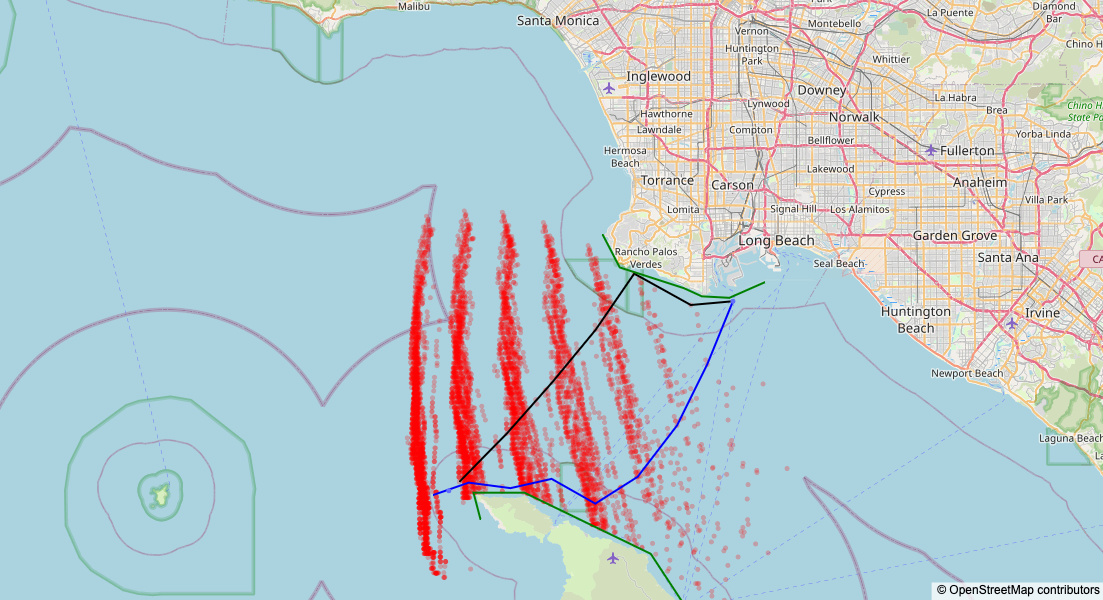

In [39]:
import plotly.graph_objects as go
import plotly.express as px
# Create the figure
fig = go.Figure()



for t,isochron in isochrons.items():
    isochron_lats = []
    isochron_lngs = []
    for route in isochron:
        route = pandas.DataFrame(route)

        isochron_lats.append(route['lat'].iloc[-1])
        isochron_lngs.append(route['lng'].iloc[-1])
        
        # # Add the first route (red line)
        # fig.add_trace(go.Scattermapbox(
        #     lat=[route['lat'].iloc[-2], route['lat'].iloc[-1]],
        #     lon=[route['lng'].iloc[-2], route['lng'].iloc[-1]],
        #     mode='lines',
        #     line=dict(color='rgba(255, 0, 0, 0.05)', width=2),
        #     hovertext=route['date']
        # ))
    
    fig.add_trace(go.Scattermapbox(
        lat=isochron_lats,
        lon=isochron_lngs,
        mode='markers',
        line=dict(color='rgba(255, 0, 0, 0.25)', width=2),
        hovertext=f"isochron={t+1}"
    ))


fig.add_trace(go.Scattermapbox(
    lat=rhumb_route['lat'],
    lon=rhumb_route['lng'],
    mode='lines',
    line=dict(color='blue', width=2),
    hovertext=rhumb_route['date']
))

min_route_dt = pandas.DataFrame(min_route)
fig.add_trace(go.Scattermapbox(
    lat=min_route_dt['lat'],
    lon=min_route_dt['lng'],
    mode='lines',
    line=dict(color='black', width=2),
    hovertext=min_route_dt['date']
))


# Add scatter points for waypoints
scatter_points = px.scatter_mapbox(waypoints, 
                                   lat="lat", 
                                   lon="lng", 
                                   hover_name="name")
fig.add_traces(scatter_points.data)
# Add the shore boundary line to the figure
for shore_boundary in weather_routing.shore_boundaries:
    boundary_lat, boundary_lon = zip(*shore_boundary)
    fig.add_trace(go.Scattermapbox(
        lat=boundary_lat,
        lon=boundary_lon,
        mode='lines',
        line=dict(color='green', width=2),
        #name='Boundary'  # Legend label
    ))
# Update layout for the map
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=9,
    mapbox_center={"lat": 33.7, "lon": -118.5},
    margin={"r":0, "t":0, "l":0, "b":0},
   # width=800,
    height=600,
    showlegend=False
)
# Show the plot
fig.show()

In [26]:
# import math
# def direction_change(mag1, mag2):
#     return math.fabs((mag2 - mag1 + 540) % 360 - 180)

# # Example usage
# mag1 = 270  # Previous direction
# mag2 = 90  # New direction

# change = direction_change(mag1, mag2)
# print(f"Change in direction: {change} degrees")

In [27]:
# red=[]
# blue=[]


# red.append([(33.68363, -118.29993),(33.60323, -118.24198)])
# blue.append([(33.69853,-118.25085),(33.59943,-118.25079)])
# red.append([(33.68363, -118.29993),(33.58692, -118.26669)])
# blue.append([(33.69853,-118.25085),(33.63149,-118.28835)])




# # Create the figure
# fig = go.Figure()

# for red_line in red:
#     lats, lngs = zip(*red_line)
#     fig.add_trace(go.Scattermapbox(
#         lat=lats,
#         lon=lngs,
#         mode='lines',
#         line=dict(color='red', width=2),
#     ))

# for blue_line in blue:
#     lats, lngs = zip(*blue_line)
#     fig.add_trace(go.Scattermapbox(
#         lat=lats,
#         lon=lngs,
#         mode='lines',
#         line=dict(color='blue', width=2),
#     ))



# # Update layout for the map
# fig.update_layout(
#     mapbox_style="open-street-map",
#     mapbox_zoom=9,
#     mapbox_center={"lat": 33.7, "lon": -118.5},
#     margin={"r":0, "t":0, "l":0, "b":0},
#    # width=800,
#     height=600
# )
# # Show the plot
# fig.show()

In [28]:
# def does_path_cross_boundary(lat, lng, dlat, dlng, boundaries):
#     """
#     Check if the path from (lat, lng) to (dlat, dlng) crosses a boundary.

#     Args:
#         lat (float): Current latitude.
#         lng (float): Current longitude.
#         dlat (float): Destination latitude.
#         dlng (float): Destination longitude.
#         boundaries (list of lists of tuples): List of Lists of (latitude, longitude) 
#             pairs defining the boundary.

#     Returns:
#         bool: True if the path crosses the boundary, False otherwise.
#     """
#     def lines_intersect(p1, p2, q1, q2):
#         """Check if two line segments (p1-p2 and q1-q2) intersect."""
#         def orientation(a, b, c):
#             """Find orientation of the triplet (a, b, c)."""
#             val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
#             #print(f"orientation({a}, {b}, {c}) val={val}")
#             if val == 0:
#                 return 0  # Collinear
#             return 1 if val > 0 else -1  # Clockwise or counterclockwise

#         def on_segment(a, b, c):
#             """Check if point b lies on segment a-c."""
#             return (min(a[0], c[0]) <= b[0] <= max(a[0], c[0]) and
#                     min(a[1], c[1]) <= b[1] <= max(a[1], c[1]))

#         o1 = orientation(p1, p2, q1)
#         o2 = orientation(p1, p2, q2)
#         o3 = orientation(q1, q2, p1)
#         o4 = orientation(q1, q2, p2)

#         #print(f"o1={o1} o2={o2} o3={o3} o4={o4}")

#         # General case
#         if o1 != o2 and o3 != o4:
#             return True

#         # Special cases
#         if o1 == 0 and on_segment(p1, q1, p2): return True
#         if o2 == 0 and on_segment(p1, q2, p2): return True
#         if o3 == 0 and on_segment(q1, p1, q2): return True
#         if o4 == 0 and on_segment(q1, p2, q2): return True

#         return False

#     # Current path as a segment
#     current_path = ((lat, lng), (dlat, dlng))
#     #print(f"current_path={current_path}")

#     # Check intersection with each boundary segment
#     for boundary in boundaries:
#         #print(f"boundary={boundary}")
#         for i in range(len(boundary) - 1):
#             boundary_segment = (boundary[i], boundary[i + 1])
#             #print(f"   boundary_segment={boundary_segment}")
#             if lines_intersect(current_path[0], current_path[1], boundary_segment[0], boundary_segment[1]):
#                 return True

#     return False
 

In [29]:
# boundaries_test=[
#   [ (33.72042, -118.20665), #Long breach, PV
#    (33.7025267, -118.26670833),
#  ],

# ]
# test_path = [(33.69853,-118.25085),(33.774391489947426,-118.32752588879168)]

# does_path_cross_boundary(test_path[0][0],test_path[0][1],test_path[1][0],test_path[1][1], boundaries_test)

In [30]:
# # Create the figure
# fig = go.Figure()

# test_path_lat, test_path_lon = zip(*test_path)
    
# # Add the first route (red line)
# fig.add_trace(go.Scattermapbox(
#     lat=test_path_lat,
#     lon=test_path_lon,
#     mode='lines',
#     line=dict(color='red', width=2)
# ))


# # Add the shore boundary line to the figure
# for test_boundary in boundaries_test:
#     boundary_lat, boundary_lon = zip(*test_boundary)
#     fig.add_trace(go.Scattermapbox(
#         lat=boundary_lat,
#         lon=boundary_lon,
#         mode='lines',
#         line=dict(color='green', width=2),
#     ))
# # Update layout for the map
# fig.update_layout(
#     mapbox_style="open-street-map",
#     mapbox_zoom=11,
#     mapbox_center={"lat": 33.71,
#                    "lon": -118.2},
#     margin={"r":0, "t":0, "l":0, "b":0},
#    # width=800,
#     height=600
# )
# # Show the plot
# fig.show()